# Predictive Maintenance
Data set: https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants

In [2]:
import pandas as pd

In [3]:
columns = ['lp','v','GTT','GTn','GGn','Ts','Tp','T48','T1','T2','P48','P1','P2','Pexh','TIC','mf','kMc','kMt']
data = pd.read_csv('data/data.csv', names=columns, skiprows=1)

# kMc = GT Compressor decay state coefficient, kMt = GT Turbine decay state coefficient
data.head()

,lp,v,GTT,GTn,GGn,Ts,Tp,T48,T1,T2,P48,P1,P2,Pexh,TIC,mf,kMc,kMt
0,1.138,3,289.964,1349.489,6677.380,7.584,7.584,464.006,288,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6,6960.180,1376.166,6828.469,28.204,28.204,635.401,288,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9,8379.229,1386.757,7111.811,60.358,60.358,606.002,288,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12,14724.395,1547.465,7792.630,113.774,113.774,661.471,288,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15,21636.432,1924.313,8494.777,175.306,175.306,731.494,288,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [4]:
data.shape

(11934, 18)

In [5]:
data.describe().round(3)

,lp,v,GTT,GTn,GGn,Ts,Tp,T48,T1,T2,P48,P1,P2,Pexh,TIC,mf,kMc,kMt
count,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.0,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000,11934.000
mean,5.167,15.000,27247.499,2136.289,8200.947,227.336,227.336,735.495,288.0,646.215,2.353,0.998,12.297,1.029,33.641,0.662,0.975,0.988
std,2.626,7.746,22148.613,774.084,1091.316,200.496,200.496,173.681,0.0,72.676,1.085,0.000,5.337,0.010,25.841,0.507,0.015,0.008
min,1.138,3.000,253.547,1307.675,6589.002,5.304,5.304,442.364,288.0,540.442,1.093,0.998,5.828,1.019,0.000,0.068,0.950,0.975
25%,3.144,9.000,8375.884,1386.758,7058.324,60.317,60.317,589.873,288.0,578.092,1.389,0.998,7.447,1.020,13.678,0.246,0.962,0.981
50%,5.140,15.000,21630.659,1924.326,8482.082,175.268,175.268,706.038,288.0,637.142,2.083,0.998,11.092,1.026,25.276,0.496,0.975,0.988
75%,7.148,21.000,39001.427,2678.079,9132.606,332.365,332.365,834.066,288.0,693.924,2.981,0.998,15.658,1.036,44.552,0.882,0.988,0.994
max,9.300,27.000,72784.872,3560.741,9797.103,645.249,645.249,1115.797,288.0,789.094,4.560,0.998,23.140,1.052,92.556,1.832,1.000,1.000


In [6]:
data.kMc

0        0.95
1        0.95
2        0.95
3        0.95
4        0.95
         ... 
11929    1.00
11930    1.00
11931    1.00
11932    1.00
11933    1.00
Name: kMc, Length: 11934, dtype: float64

In [7]:
import pandas as pd

# Define a custom function to determine decay status
def get_decay_status(coeff):
    if coeff < 0.975:
        return 'done'
    elif 0.975 <= coeff < 0.99:
        return 'decaying'
    elif 0.99 <= coeff <= 1:
        return 'not decaying'
    else:
        return 'unknown'  # Handle any other cases here

# Apply the custom function to create the "decay_status" column
data['decay_status_kMc'] = data['kMc'].apply(get_decay_status)

# Print the updated DataFrame
data['decay_status_kMc'].value_counts()

decay_status_kMc
done            5850
decaying        3510
not decaying    2574
Name: count, dtype: int64

In [8]:
# Apply the custom function to create the "decay_status" column
data['decay_status_kMt'] = data['kMt'].apply(get_decay_status)

# Print the updated DataFrame
data['decay_status_kMt'].value_counts()

decay_status_kMt
decaying        6885
not decaying    5049
Name: count, dtype: int64

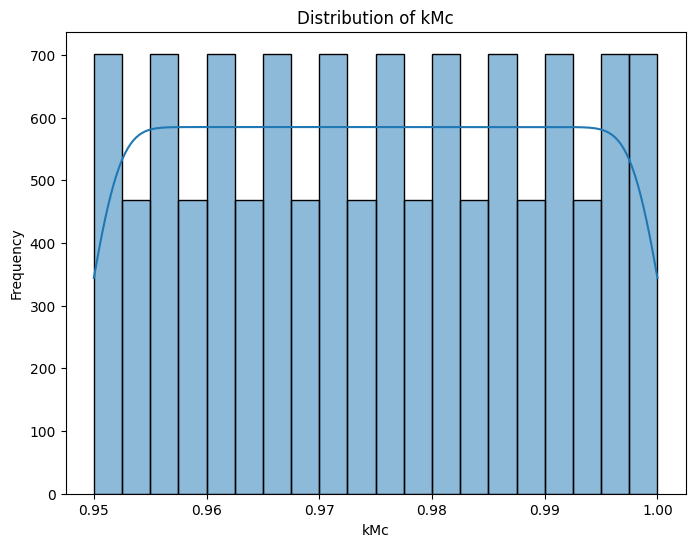

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plot of 'kMc'
plt.figure(figsize=(8, 6))
sns.histplot(data['kMc'], bins=20, kde=True)
plt.title('Distribution of kMc')
plt.xlabel('kMc')
plt.ylabel('Frequency')
plt.show()

# Create a pairplot grid
sns.set(style="ticks")
#sns.pairplot(data, diag_kind='kde')
#plt.suptitle('Pairplot of All Variables', y=1.02)
#plt.show()

### Training a simple MLP as a baseline to estimate compressor decay

- Defining features and target
- splitting data into train, validation and test data, while shuffling the dataset and keeping distribution

In [10]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

torch.manual_seed(0)

# Split features and target
features = data.drop(columns=['kMc'])
target = data['kMc']

# Split data into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=1 - train_size, random_state=42, stratify=target, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size + val_size), random_state=42, stratify=y_temp)

- Checking for equal distribution between all three datasets

In [11]:
X_val.decay_status_kMc.value_counts()

decay_status_kMc
done            878
decaying        525
not decaying    387
Name: count, dtype: int64

In [12]:
X_train.decay_status_kMc.value_counts()

decay_status_kMc
done            4094
decaying        2458
not decaying    1801
Name: count, dtype: int64

In [13]:
X_test.decay_status_kMc.value_counts()

decay_status_kMc
done            878
decaying        527
not decaying    386
Name: count, dtype: int64

In [14]:
X_train = X_train.drop(columns=['decay_status_kMc', 'decay_status_kMt'])
X_val = X_val.drop(columns=['decay_status_kMc', 'decay_status_kMt'])
X_test = X_test.drop(columns=['decay_status_kMc', 'decay_status_kMt'])

In [15]:
# scale the input data for the neural network to improve convergence and speed up training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Defining different MLPs
- starting with a simple MLP to train a regression model

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train_scaled.shape[1]
hidden_dim = 64  # Adjust this as needed
output_dim = 1
mlp_model = MLP(input_dim, hidden_dim, output_dim)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

In [18]:
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [19]:
num_epochs = 1000

def train(model, epochs, X_train_scaled, y_train, X_val_tensor, y_val_tensor, lr=0.001, patience=10):
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    counter = 0
    
    inputs = torch.tensor(X_train_scaled, dtype=torch.float32)
    targets = torch.tensor(y_train.values, dtype=torch.float32)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, targets)
        train_loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor).squeeze()
            val_loss = criterion(y_val_pred, y_val_tensor)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            
        # keep count of training loss for early stopping
        if train_loss < best_loss:
            best_loss = train_loss
            counter = 0
        else:
            counter += 1
            
        # check if early stopping criteria has been met
        if counter >= patience:
            print("Early stopping")
            break

In [42]:
train(mlp_model, num_epochs, X_train_scaled, y_train, X_val_tensor, y_val_tensor)

C:\Users\Luca\miniconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8353])) that is different to the input size (torch.Size([8353, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/1000], Train Loss: 0.0447, Val Loss: 0.0430
Epoch [200/1000], Train Loss: 0.0040, Val Loss: 0.0040
Epoch [300/1000], Train Loss: 0.0020, Val Loss: 0.0022
Epoch [400/1000], Train Loss: 0.0013, Val Loss: 0.0014
Epoch [500/1000], Train Loss: 0.0008, Val Loss: 0.0010
Epoch [600/1000], Train Loss: 0.0006, Val Loss: 0.0008
Epoch [700/1000], Train Loss: 0.0005, Val Loss: 0.0007
Epoch [800/1000], Train Loss: 0.0004, Val Loss: 0.0007
Epoch [900/1000], Train Loss: 0.0004, Val Loss: 0.0006
Epoch [1000/1000], Train Loss: 0.0004, Val Loss: 0.0006


In [20]:
def evaluate(model, X_test_scaled, y_test):

    model.eval()
    with torch.no_grad():
        test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
        test_targets = torch.tensor(y_test.values, dtype=torch.float32)
        test_outputs = model(test_inputs)

    mae = nn.L1Loss()
    mae = mae(test_outputs, test_targets)
    mse_o = nn.MSELoss()
    mse = mse_o(test_outputs, test_targets)
    rmse = torch.sqrt(mse_o(test_outputs, test_targets))
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

In [44]:
evaluate(mlp_model, X_test_scaled, y_test)

Mean Absolute Error (MAE): 0.0159
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0195


C:\Users\Luca\miniconda3\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1791])) that is different to the input size (torch.Size([1791, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\Luca\miniconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1791])) that is different to the input size (torch.Size([1791, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [45]:
test_inputs = torch.tensor(X_test_scaled, dtype=torch.float32)
test_outputs = mlp_model(test_inputs)
eval_df = pd.DataFrame({'target': y_test.tolist(), 'prediction': [value.item() for value in test_outputs]})
eval_df['decay_status_kMc_target'] = eval_df['target'].apply(get_decay_status)
eval_df['decay_status_kMc_pred'] = eval_df['prediction'].apply(get_decay_status)

eval_df.head()

,target,prediction,decay_status_kMc_target,decay_status_kMc_pred
0,0.999,0.963233,not decaying,done
1,0.963,0.958043,done,done
2,0.955,0.957175,done,done
3,0.952,0.968837,done,done
4,0.978,0.970015,decaying,done


In [46]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

y_true = eval_df['decay_status_kMc_target']
y_pred = eval_df['decay_status_kMc_pred']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-score: {f1:.4f}')

C:\Users\Luca\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2803
Recall: 0.2803
Precision: 0.2600
F1-score: 0.2655


### Another MLP

In [67]:
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [83]:
input_dim = X_train_scaled.shape[1]
hidden_dim1 = 24
hidden_dim2 = 12
hidden_dim3 = 6
output_dim = 1

mlp2_model = MLP2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
train(mlp2_model, 5000, X_train_scaled, y_train, X_val_tensor, y_val_tensor)

Epoch [100/1000], Train Loss: 0.0912, Val Loss: 0.0885
Epoch [200/1000], Train Loss: 0.0033, Val Loss: 0.0031
Epoch [300/1000], Train Loss: 0.0011, Val Loss: 0.0012
Epoch [400/1000], Train Loss: 0.0007, Val Loss: 0.0008
Epoch [500/1000], Train Loss: 0.0006, Val Loss: 0.0007
Epoch [600/1000], Train Loss: 0.0005, Val Loss: 0.0006
Epoch [700/1000], Train Loss: 0.0004, Val Loss: 0.0005
Epoch [800/1000], Train Loss: 0.0004, Val Loss: 0.0005
Epoch [900/1000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [1000/1000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [1100/1000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [1200/1000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [1300/1000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [1400/1000], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [1500/1000], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [1600/1000], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [1700/1000], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [1800/1000], Train Loss: 0.0002, Val Loss: 0.0003
E

In [34]:
evaluate(mlp2_model, X_test_scaled, y_test)

NameError: name 'mlp2_model' is not defined

### MLP3

- just increasing the size of the hidden layers does not work
- adding an additional layer helps to converge faster, but without better results
    - the bigger the network, the faster the convergence (early stopping is applied), but without better results on the test set
- the RMSE is the same on the training, validation and test set, so overfitting isn't a problem (yet), is it?
    - so early stopping based on the training loss shouln't be an issue right now, right?
- increasing the learning rate to 0.01 leads to instant early stopping and underfitting
- increasing the learning rate to 0.005 leads to way faster convergence with early stopping after ca. 400 epochs, but with similar performance on all datasets

ToDo:
- further increase network size
- experiment with learning rate and batch size

Question:
- are there other neural network types suitable for this problem?
    - LSTM, attention and CNN are not suitable imo

In [41]:
class MLP3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, hidden_dim5)
        self.fc6 = nn.Linear(hidden_dim5, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [44]:
input_dim = X_train_scaled.shape[1]
hidden_dim1 = 192
hidden_dim2 = 288
hidden_dim3 = 192
hidden_dim4 = 96
hidden_dim5 = 24
output_dim = 1

mlp3_model = MLP3(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)
train(mlp3_model, 5000, X_train_scaled, y_train, X_val_tensor, y_val_tensor, lr=0.005)

Epoch [100/5000], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [200/5000], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [300/5000], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [400/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [500/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [600/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [700/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [800/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [900/5000], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [1000/5000], Train Loss: 0.0002, Val Loss: 0.0002
Early stopping


In [45]:
evaluate(mlp3_model, X_test_scaled, y_test)

Mean Absolute Error (MAE): 0.0128
Mean Squared Error (MSE): 0.0002
Root Mean Squared Error (RMSE): 0.0148


### XGBoostRegressor

In [110]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create an XGBRegressor model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Maximum depth of each tree
    objective='reg:squarederror',  # Regression task
    random_state=42
)

# Train the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict the target variable on the test data
y_pred = xgb_model.predict(X_test_scaled)

# Calculate Mean Squared Error (MSE) as a performance metric
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = mean_squared_error(y_test, y_pred, squared=True)

print("Mean Absolute Error:", "{:.10f}".format(mae))
print("Mean Squared Error:", "{:.10f}".format(mse))
print("Root Mean Squared Error:", "{:.10f}".format(rmse))

Mean Absolute Error: 0.0029602187
Mean Squared Error: 0.0039781134
Root Mean Squared Error: 0.0000158254
